In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install joblib==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 5.6 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


In [8]:
# set project folder directory
DATA_DIR = '/content/drive/MyDrive/W281 Project/data'

In [9]:
# load some lib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import joblib
import gzip


# read in metadata
df_meta = pd.read_csv(f"{DATA_DIR}/raw/Chest_xray_Corona_Metadata.csv", index_col = 0)
df_meta

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...
5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [10]:

# read in summary of data set
df_data_summary = pd.read_csv(f"{DATA_DIR}/raw/Chest_xray_Corona_dataset_Summary.csv", index_col = 0)
df_data_summary['Label_2_Virus_category'] = np.where((df_data_summary['Label'] == 'Normal'), 
                                              'Normal',
                                              np.where(
                                                  (df_data_summary['Label_2_Virus_category'] != df_data_summary['Label_2_Virus_category']) & 
                                                  ~(df_data_summary['Label_1_Virus_category'] != df_data_summary['Label_1_Virus_category']),
                                                  df_data_summary['Label_1_Virus_category'],
                                                  df_data_summary['Label_2_Virus_category']
                                              ))

df_data_summary['Label_1_Virus_category'] = np.where((df_data_summary['Label'] == 'Normal'), 
                                              'Normal', 
                                              df_data_summary['Label_1_Virus_category']
                                              )

df_data_summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,Normal,Normal,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,Virus,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,bacteria,2772
6,Pnemonia,bacteria,Streptococcus,5


In [11]:
# creating data label map
df_data_summary = df_data_summary[df_data_summary['Label_1_Virus_category'] != 'Stress-Smoking']
label_map = df_data_summary[['Label_1_Virus_category']].drop_duplicates().reset_index(drop=True).to_dict()['Label_1_Virus_category']
label_map = { val.lower(): key for key, val in label_map.items()}
label_map

{'normal': 0, 'virus': 1, 'bacteria': 2}

# Image Visualization
Read in some image to show some visualization

In [12]:
# load image data
def grab_one_and_plot(df, col_category, data_set = 'train'):
  """
    For data visualization, grab each image from the specified column directory
    Show the image
  """
  # copy the meta; avoid mutation
  df_copy = df.copy()


  # instantitae canvas for plotting
  plt.figure(figsize=(15,5))

  for i, cat in enumerate(df_copy[col_category].unique()):

      print(cat)

      # locate the image and build path to the image
      img_meta = df_copy[df_copy[col_category] == cat].iloc[153]
      train_test = data_set
      path = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{img_meta['X_ray_image_name']}"


      # grab the image path and plot
      img = Image.open(path)
      plt.subplot(1, len(df_copy[col_category].unique()), i+1)
      plt.imshow(img, cmap='gray')
      plt.axis('off')
      plt.title(f"{train_test}: {cat} Chest X-ray")
      
      
  plt.show()

# grab_one_and_plot(df_meta, "Label")


## Image Resizing

Interesting, the X-ray images are not of even size. Here we want to resize each image to (224 x 224) because images of even dimension are easier to model.



In [13]:

# def resize_image(image):
#     """
#         Resize Image to fit VGG16 Imagenet input dimension
#         dim = (224 x 224 x 3)
#     """
#     width, height = image.size
#     if width > height:
#         left = (width - height) / 2
#         right = width - left
#         top = 0
#         bottom = height
#     else:
#         top = (height - width) / 2
#         bottom = height - top
#         left = 0
#         right = width
#     image = image.crop((left, top, right, bottom))
#     image = image.resize([224, 224], Image.LANCZOS)
#     return image


# def main(path_in, path_out):
#     """
#       Function to initiate the resizing process
#     """
#     if not os.path.exists(path_out):
#         os.makedirs(path_out)

#     print('Start resizing images.')
#     image_files = os.listdir(path_in)
#     num_images = len(image_files)
#     for i, image_file in tqdm(enumerate(image_files)):
#         with open(os.path.join(path_in, image_file), 'r+b') as f:
#             with Image.open(f) as image:
#                 image = resize_image(image)
#                 image.save(os.path.join(path_out, image_file), image.format)


# path_in = f'{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
# path_out = f'{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test_resized'
# main(path_in, path_out)

In [14]:
# grab_one_and_plot(df_meta, "Label", "train_resized")

# Simple Model

1. pre-process the image to grab the label per image
2. do a simple model with multiple labels

In [15]:
df_meta = df_meta[df_meta['Label_1_Virus_category'] != 'Stress-Smoking']

In [16]:
df_meta['Label_1_Virus_category'].unique()

array([nan, 'Virus', 'bacteria'], dtype=object)

In [17]:
# fill some label nan
# certain bacteria/virus does not have a distinct label, for these we will be using the regular virus/barteria term
# in case of normal, we will label it as nomal
df_meta['Label_2_Virus_category'] = np.where((df_meta['Label'] == 'Normal'), 
                                              'Normal',
                                              np.where(
                                                  (df_meta['Label_2_Virus_category'] != df_meta['Label_2_Virus_category']) & 
                                                  ~(df_meta['Label_1_Virus_category'] != df_meta['Label_1_Virus_category']),
                                                  df_meta['Label_1_Virus_category'],
                                                  df_meta['Label_2_Virus_category']
                                              ))


df_meta['Label_1_Virus_category'] = np.where((df_meta['Label'] == 'Normal'), 
                                              'Normal',
                                              df_meta['Label_1_Virus_category'])

# select and rename meta dataset columns
df_meta = df_meta[['Dataset_type', 'X_ray_image_name', 'Label_1_Virus_category']]
df_meta['Label_1_Virus_category'] = df_meta['Label_1_Virus_category'].str.lower()
df_meta['label'] = df_meta['Label_1_Virus_category'].map(label_map)


# get a list of unique labels to train from
label_list = sorted(list(df_meta['label'].unique()))
print(label_list)

# get train data
df_train = df_meta[df_meta['Dataset_type'] == 'TRAIN']
df_train

[0, 1, 2]


<ipython-input-17-080ed7f18449>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta['Label_2_Virus_category'] = np.where((df_meta['Label'] == 'Normal'),
<ipython-input-17-080ed7f18449>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta['Label_1_Virus_category'] = np.where((df_meta['Label'] == 'Normal'),


,Dataset_type,X_ray_image_name,Label_1_Virus_category,label
0,TRAIN,IM-0128-0001.jpeg,normal,0
1,TRAIN,IM-0127-0001.jpeg,normal,0
2,TRAIN,IM-0125-0001.jpeg,normal,0
3,TRAIN,IM-0122-0001.jpeg,normal,0
4,TRAIN,IM-0119-0001.jpeg,normal,0
...,...,...,...,...
5304,TRAIN,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,virus,1
5305,TRAIN,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,virus,1
5306,TRAIN,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,virus,1
5307,TRAIN,1-s2.0-S0140673620303706-fx1_lrg.jpg,virus,1


In [18]:
# get test data
df_test = df_meta[df_meta['Dataset_type'] == 'TEST']
df_test

,Dataset_type,X_ray_image_name,Label_1_Virus_category,label
5309,TEST,IM-0021-0001.jpeg,normal,0
5310,TEST,IM-0019-0001.jpeg,normal,0
5311,TEST,IM-0017-0001.jpeg,normal,0
5312,TEST,IM-0016-0001.jpeg,normal,0
5313,TEST,IM-0015-0001.jpeg,normal,0
...,...,...,...,...
5928,TEST,person1637_virus_2834.jpeg,virus,1
5929,TEST,person1635_virus_2831.jpeg,virus,1
5930,TEST,person1634_virus_2830.jpeg,virus,1
5931,TEST,person1633_virus_2829.jpeg,virus,1


In [19]:
# import some modeling libraries
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16 # Load in based VGG16 model
# from keras.preprocessing.image import ImageDataGenerator


from tqdm.notebook import tqdm    # progress bar

In [20]:
# load in the base model
# freeze all the weights (avoid overfitting)
cnn_model = VGG16(input_shape = (224, 224, 3),    # Shape of our images
                    include_top = False,           # Leave out the last fully connected layer
                    weights = 'imagenet')

for layer in cnn_model.layers:
    layer.trainable = False
cnn_model.layers

58889256/58889256 [==============================] - 3s 0us/step


In [21]:
# # build a list of training data
# data_path = f'{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train_resized'

# train_image_data = []
# train_label = []
# for i, row in tqdm(df_train.iterrows()):
#     img_name = row['X_ray_image_name']
#     label = row['label']
#     path = f"{data_path}/{img_name}"
#     img = Image.open(path)
#     img = img.convert("L")
#     # print(np.array(img).shape)
#     # print(np.array(img))
#     train_image_data.append(np.array(img))
#     train_label.append(label)

In [39]:
# # build a list of training data
# data_path = f'{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test_resized'

# test_image_data = []
# test_label = []
# for i, row in tqdm(df_test.iterrows()):
#     img_name = row['X_ray_image_name']
#     label = row['label']
#     path = f"{data_path}/{img_name}"
#     img = Image.open(path)
#     img = img.convert("L")
#     # print(np.array(img).shape)
#     # print(np.array(img))
#     test_image_data.append(np.array(img))
#     test_label.append(label)

In [40]:
# train_image_data = np.array(train_image_data)
# train_image_data[:5]

In [41]:
# test_image_data = np.array(test_image_data)
# test_image_data[:5]

In [42]:
# train_label = np.array(train_label)
# train_label[:5]

In [43]:
# test_label = np.array(test_label)
# test_label[:5]

In [44]:
# # save on data loading by pickling the dataset
# # output the dataset as a pickle so we don't have to load it everytime
# joblib.dump(train_image_data, f"{DATA_DIR}/processed/image_data.pkl")
# joblib.dump(train_label, f"{DATA_DIR}/processed/image_caption_data.pkl")

In [45]:
# joblib.dump(test_image_data, f"{DATA_DIR}/processed/test_image_data.pkl")
# joblib.dump(test_label, f"{DATA_DIR}/processed/test_image_caption_data.pkl")

In [69]:
# import data
train_image_data = joblib.load(f"{DATA_DIR}/processed/image_data.pkl")
train_label = joblib.load(f"{DATA_DIR}/processed/image_caption_data.pkl")

test_image_data = joblib.load(f"{DATA_DIR}/processed/test_image_data.pkl")
test_label = joblib.load(f"{DATA_DIR}/processed/test_image_caption_data.pkl")

In [48]:
# # testing some model input
# # Experimenting with image encoding trained model
# # states_value = encoder_model.predict(train_image_data[1].reshape(1,224,224,3))
# source_image = keras.layers.Input(shape=(224,224,3), dtype='int64', name='source_image_layer')
# encoder_model = keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)

# # source_image(train_image_data[1].reshape(1,224,224,3))
# test = encoder_model.predict(train_image_data[1])
# test = tf.convert_to_tensor(test, dtype='float32')
# test.shape

In [49]:
# image_shape = (224, 224)
# source_image = keras.layers.Input(shape=image_shape, dtype='float64', name='source_image_layer')

# reshaped_image = keras.layers.Reshape(input_shape=(224, 224),
#                                         target_shape=(224, 224, 1), 
#                                         name='filter_reshape_layer')(source_image)

# conv_layer_1 = keras.layers.Conv2D(filters=32,
#                                     kernel_size=(3, 3),
#                                     strides=(1, 1),
#                                     padding='same',
#                                     name='conv_1',
#                                     activation='relu',
#                                     input_shape=image_shape)
# conv_1_out = conv_layer_1(reshaped_image)
# conv_1_out


In [70]:
def image_label_fine_tuning(image_shape=(224, 224),
                            encoder_model=cnn_model,
                            hidden_dimensions=[256, 128],
                            dropout_rate=0.3,
                            label_list = []):
    """
        Image captioning model architecture:
            1. ImageNet pretrained CNN model to encode a given image
            2. decoder takes in the CNN image hidden state and run through LSTM
    """

    # # Encoder architecture: take in source image, feed through CNN, catch the last pooled pooled layer
    # # create the context vecto
    source_image = keras.layers.Input(shape=image_shape, dtype='float64', name='source_image_layer')
    # cnn_model_layer = keras.Model(inputs=encoder_model.input, outputs=encoder_model.layers[-2].output)
    # source_image_encoding = cnn_model_layer(source_image)

    reshaped_image = keras.layers.Reshape(input_shape=(224, 224),
                                        target_shape=(224, 224, 1), 
                                        name='filter_reshape_layer')(source_image)
    
    conv_layer_1 = keras.layers.Conv2D(filters=32,
                                        kernel_size=(5, 5),
                                        strides=(1, 1),
                                        padding='same',
                                        data_format='channels_last',
                                        name='conv_1',
                                        activation='relu')
    conv_1_out = conv_layer_1(reshaped_image)
    max_pooling_1_out= keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_1')(conv_1_out)

    conv_layer_2 = keras.layers.Conv2D(filters=32,
                                        kernel_size=(3, 3),
                                        strides=(1, 1),
                                        padding='same',
                                        name='conv_2',
                                        activation='relu')
    conv_2_out = conv_layer_2(max_pooling_1_out)
    max_pooling_2_out=keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2')(conv_2_out)


    # flatten the final image state
    flatten_layer = keras.layers.Flatten()(max_pooling_2_out)
    last_hidden_output = flatten_layer
    
    # add a fully connected feed-forward net
    # some final dropout layer
    # add final classification layer
    for hidden_layer_size in hidden_dimensions:
        last_hidden_output = keras.layers.Dense(hidden_layer_size, activation='relu')(last_hidden_output)

    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)

    output = keras.layers.Dense(len(label_list), activation='softmax', name="output_layer")(last_hidden_output)

    # instantiate and compile the model
    model = keras.Model(inputs=source_image, outputs=output)
    model.compile(optimizer='Adam', 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
    
    return model


In [71]:
img_classification_model = image_label_fine_tuning(label_list = label_list)
img_classification_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_image_layer (InputLa  [(None, 224, 224)]       0         
 yer)                                                            
                                                                 
 filter_reshape_layer (Resha  (None, 224, 224, 1)      0         
 pe)                                                             
                                                                 
 conv_1 (Conv2D)             (None, 224, 224, 32)      832       
                                                                 
 pool_1 (MaxPooling2D)       (None, 112, 112, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 112, 112, 32)      9248      
                                                                 
 pool_2 (MaxPooling2D)       (None, 56, 56, 32)        0   

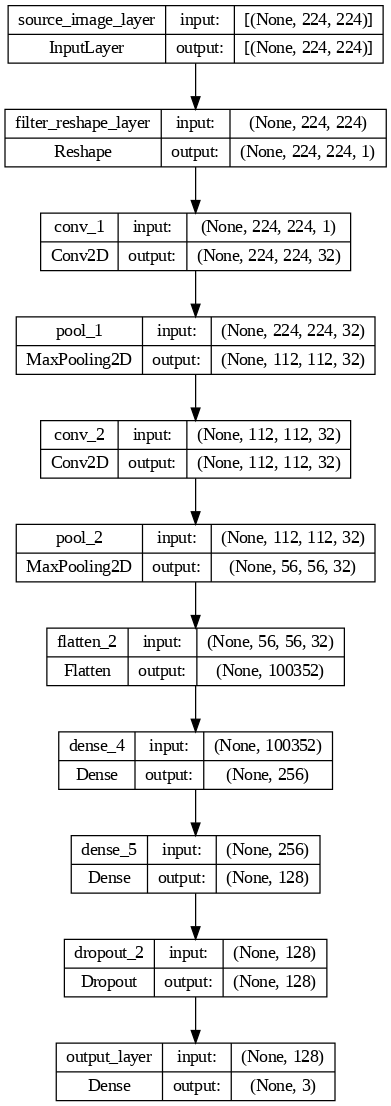

In [72]:
keras.utils.plot_model(img_classification_model, show_shapes=True, dpi=90)

In [73]:
img_classification_model.fit(x=train_image_data,
                            y=train_label,
                            validation_split=0.1,
                            batch_size=258,
                            epochs=15)

Epoch 1/15
19/19 [==============================] - 6s 204ms/step - loss: 638.3530 - accuracy: 0.4263 - val_loss: 1.7278 - val_accuracy: 0.4423
Epoch 2/15
19/19 [==============================] - 4s 192ms/step - loss: 0.8483 - accuracy: 0.6368 - val_loss: 1.1202 - val_accuracy: 0.4556
Epoch 3/15
19/19 [==============================] - 4s 192ms/step - loss: 0.6641 - accuracy: 0.7037 - val_loss: 1.0791 - val_accuracy: 0.4896
Epoch 4/15
19/19 [==============================] - 4s 193ms/step - loss: 0.5561 - accuracy: 0.7577 - val_loss: 1.1557 - val_accuracy: 0.5595
Epoch 5/15
19/19 [==============================] - 4s 196ms/step - loss: 0.4624 - accuracy: 0.7992 - val_loss: 1.3999 - val_accuracy: 0.5444
Epoch 6/15
19/19 [==============================] - 4s 199ms/step - loss: 0.3905 - accuracy: 0.8318 - val_loss: 1.2392 - val_accuracy: 0.5784
Epoch 7/15
19/19 [==============================] - 4s 201ms/step - loss: 0.3282 - accuracy: 0.8591 - val_loss: 1.6824 - val_accuracy: 0.5652
Epoc

In [74]:
# save model
img_classification_model.save(f"{DATA_DIR}/outputs/pneumonia_base_cnn_model.h5")

In [75]:
# load the model
cnn_model = keras.models.load_model(f"{DATA_DIR}/outputs/pneumonia_base_cnn_model.h5")


In [77]:
# np.argmax(cnn_model.predict(test_image_data[620].reshape(1, 224, 224)))

In [78]:
y_pred = np.argmax(cnn_model.predict(test_image_data), axis=-1)
y_pred

20/20 [==============================] - 0s 17ms/step


array([1, 2, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 2, 1, 0, 2, 1, 0, 0, 0, 2,
       0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1,
       2, 0, 2, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 0, 2,
       0, 0, 2, 0, 0, 2, 2, 1, 0, 2, 2, 2, 1, 2, 0, 2, 0, 0, 2, 2, 1, 0,
       2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 2, 0, 1, 1, 1, 1, 2, 0,
       2, 0, 2, 0, 1, 2, 1, 2, 1, 2, 2, 2, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 0, 0, 2,
       0, 0, 2, 2, 1, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 2, 0, 1, 1, 2, 1, 1, 1, 1, 2,
       1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

Text(0.5, 1.0, 'CNN Base Confusion Matrix')

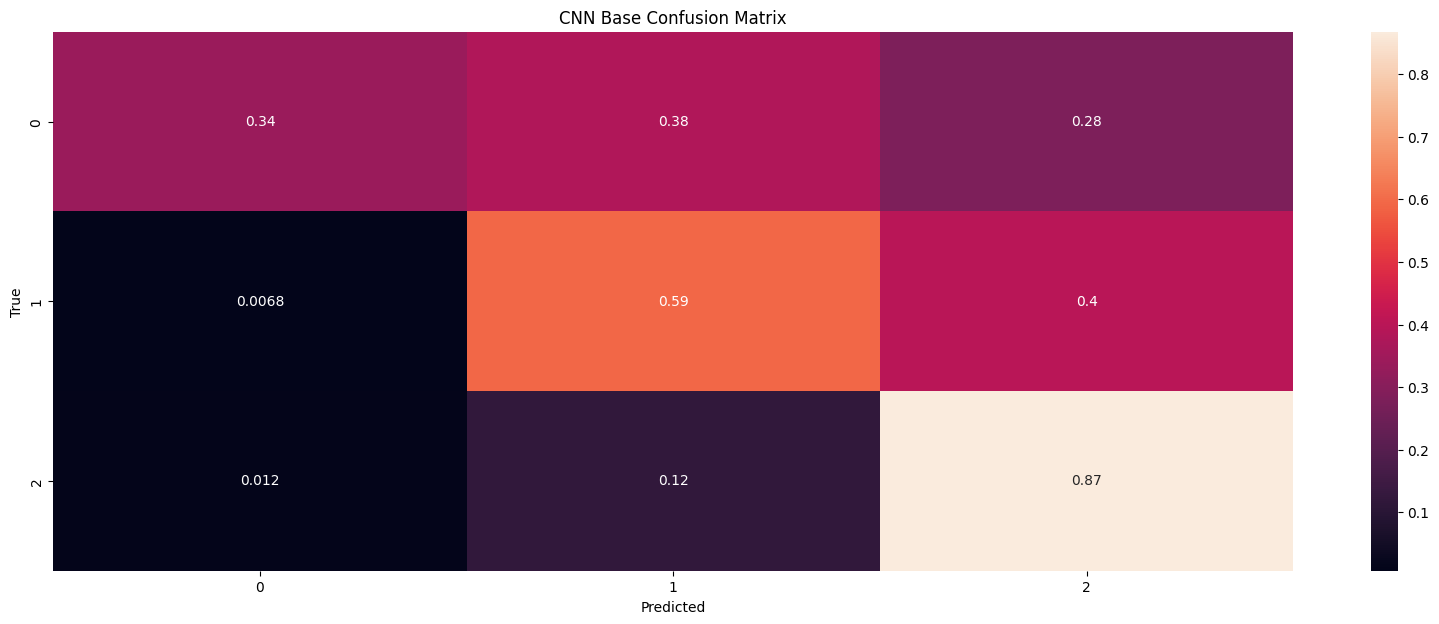

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(20,7))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN Base Confusion Matrix")


In [80]:
from sklearn.metrics import classification_report
print(classification_report(test_label, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.34      0.50       234
           1       0.43      0.59      0.50       148
           2       0.63      0.87      0.73       242

    accuracy                           0.60       624
   macro avg       0.67      0.60      0.57       624
weighted avg       0.70      0.60      0.59       624



In [22]:
# joblib load
train_image_data = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/image_data_aug.gz", 'rb') )
train_label = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/image_caption_data_aug.gz", 'rb') )

# # loading test set
# test_image_data = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/test_image_data_aug.gz", 'rb') )
# test_label = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/test_image_caption_data_aug.gz", 'rb') )
test_image_data = joblib.load(f"{DATA_DIR}/processed/test_image_data.pkl")
test_label = joblib.load(f"{DATA_DIR}/processed/test_image_caption_data.pkl")

In [23]:
img_classification_model = image_label_fine_tuning(label_list = label_list)
img_classification_model.summary()

NameError: ignored

In [83]:
img_classification_model.fit(x=train_image_data['img'],
                            y=train_label,
                            validation_split=0.1,
                            batch_size=258,
                            epochs=10)

Epoch 1/10
70/70 [==============================] - 16s 201ms/step - loss: 72.3260 - accuracy: 0.5727 - val_loss: 0.9735 - val_accuracy: 0.5783
Epoch 2/10
70/70 [==============================] - 14s 200ms/step - loss: 0.6073 - accuracy: 0.7326 - val_loss: 0.8024 - val_accuracy: 0.5934
Epoch 3/10
70/70 [==============================] - 14s 201ms/step - loss: 0.5065 - accuracy: 0.7814 - val_loss: 0.8705 - val_accuracy: 0.6157
Epoch 4/10
70/70 [==============================] - 14s 199ms/step - loss: 0.3635 - accuracy: 0.8469 - val_loss: 1.0905 - val_accuracy: 0.6086
Epoch 5/10
70/70 [==============================] - 14s 197ms/step - loss: 0.2614 - accuracy: 0.8952 - val_loss: 1.0984 - val_accuracy: 0.6101
Epoch 6/10
70/70 [==============================] - 14s 196ms/step - loss: 0.1985 - accuracy: 0.9195 - val_loss: 1.4371 - val_accuracy: 0.6005
Epoch 7/10
70/70 [==============================] - 14s 197ms/step - loss: 0.1480 - accuracy: 0.9427 - val_loss: 1.8313 - val_accuracy: 0.621

In [84]:
# save model
img_classification_model.save(f"{DATA_DIR}/outputs/pneumonia_base_cnn_model_augmented.h5")

In [24]:
# load the model
cnn_model = keras.models.load_model(f"{DATA_DIR}/outputs/pneumonia_base_cnn_model_augmented.h5")


In [25]:
y_pred = np.argmax(cnn_model.predict(test_image_data), axis=-1)
y_pred

20/20 [==============================] - 8s 13ms/step


array([1, 2, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1, 0, 0, 2,
       2, 0, 2, 0, 0, 2, 0, 0, 1, 1, 0, 0, 2, 1, 2, 2, 2, 2, 0, 0, 0, 1,
       0, 0, 2, 0, 0, 2, 0, 1, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0,
       1, 2, 2, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 2, 0, 0, 1, 2, 0, 0,
       2, 0, 1, 1, 0, 1, 0, 0, 1, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 2, 0, 0,
       2, 0, 1, 0, 1, 2, 1, 2, 2, 0, 1, 1, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2,
       0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 2, 1, 1, 1, 0, 2, 1, 2, 0, 0, 2, 2, 2, 2, 1, 2, 1, 0, 0, 0, 0,
       0, 0, 1, 2, 1, 1, 0, 2, 0, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,

Text(0.5, 1.0, 'CNN Augmented Confusion Matrix')

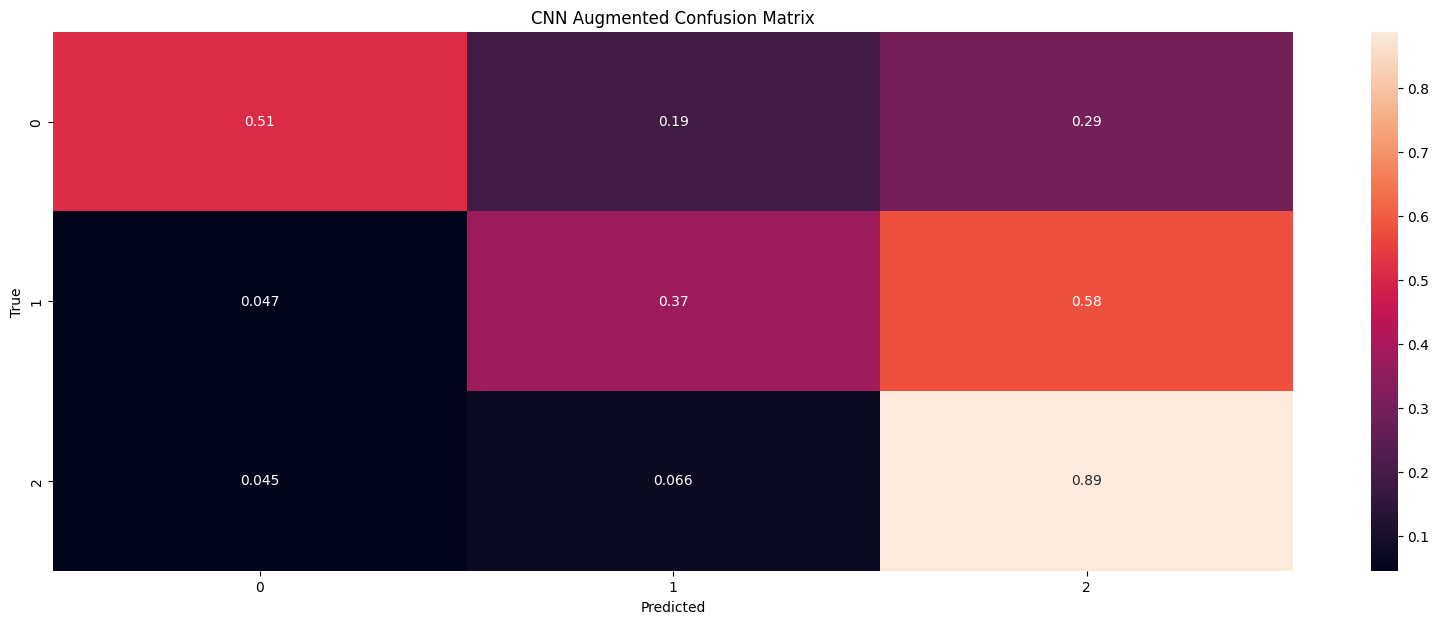

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(20,7))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN Augmented Confusion Matrix")

In [28]:
from sklearn.metrics import classification_report
print(classification_report(test_label, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.51      0.65       234
           1       0.47      0.37      0.42       148
           2       0.58      0.89      0.70       242

    accuracy                           0.62       624
   macro avg       0.64      0.59      0.59       624
weighted avg       0.66      0.62      0.61       624

